<a href="https://colab.research.google.com/github/WhiteTeaDragon/dla-hw2-kws/blob/main/seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and misc

In [ ]:
!pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 6.0 MB/s 
     |████████████████████████████████| 831.4 MB 7.0 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [ ]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [ ]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    dropout: float = 0.1
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-21 19:39:45--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.202.128, 2607:f8b0:4001:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.202.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  34.0MB/s    in 15s     

2021-11-21 19:40:01 (92.7 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [ ]:
dataset.csv.sample(5)

,path,keyword,label
6139,speech_commands/five/b00dff7e_nohash_1.wav,five,0
37714,speech_commands/zero/cee22275_nohash_1.wav,zero,0
382,speech_commands/no/c0445658_nohash_1.wav,no,0
57167,speech_commands/off/789e4ee7_nohash_0.wav,off,0
23365,speech_commands/on/919d3c0e_nohash_0.wav,on,0


### Augmentations

In [ ]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

### Creating Fixed Split

In [ ]:
indexes = torch.randperm(len(dataset))
torch.save(indexes, "split_indexes.pt")

### Using Fixed Split

In [ ]:
import gdown
url = "https://drive.google.com/uc?id=1leEkCji437BPCRR2-fl5tk8bsl0JbJQb"
file = "/content/split_indexes.pt"
gdown.download(url, file, quiet=False)
indexes = torch.load(file)

Downloading...
From: https://drive.google.com/uc?id=1leEkCji437BPCRR2-fl5tk8bsl0JbJQb
To: /content/split_indexes.pt
100%|██████████| 519k/519k [00:00<00:00, 57.4MB/s]


In [ ]:
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [ ]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [ ]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [ ]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [ ]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [ ]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [ ]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [ ]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [ ]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [ ]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [ ]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=config.dropout,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

In [ ]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [ ]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

70443

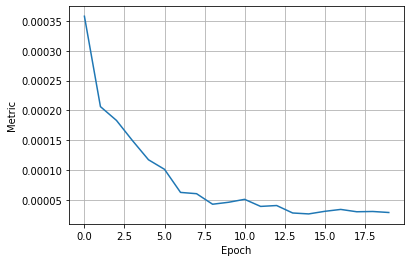

END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0003579693092011677,
              0.00020628021723663456,
              0.00018313210016946343,
              0.00014924239745627314,
              0.00011707134844644596,
              0.00010103058054839077,
              6.230119674691078e-05,
              6.0146912070125835e-05,
              4.247103613484331e-05,
              4.575915485204137e-05,
              5.068238160646679e-05,
              3.880696192003456e-05,
              4.028691372015275e-05,
              2.7766998894959377e-05,
              2.6209468976286607e-05,
              3.055384361534322e-05,
              3.3752449118824465e-05,
              2.9831770358027494e-05,
              3.0291271521773864e-05,
              2.8590520461154177e-05]})

In [ ]:
torch.save(model, "base_crnn_model.pt")

# Streaming

In [ ]:
class StreamingAttention(Attention):
    def __init__(self, hidden_size: int):
        super().__init__(hidden_size)
    
    def forward(self, input, previous_energy=None):
        energy = self.energy(input)
        if previous_energy is not None:
            energy = torch.cat((previous_energy, energy), dim=-2)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2), energy


class StreamingCRNN(CRNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attention = StreamingAttention(config.hidden_size)

    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        context_vector, _ = self.attention(gru_output)
        output = self.classifier(context_vector)
        return output

In [ ]:
class Streaming(nn.Module):
    def __init__(self, model, max_window_length):
        super().__init__()
        self.max_window_length = max_window_length
        self.model = model
        self.time_kernel_size = model.conv[0].weight.shape[-1]
        self.time_stride_size = model.conv[0].stride[-1]
        assert self.max_window_length >= self.time_kernel_size

    def forward(self, input):
        self.model.eval()
        input = input.unsqueeze(dim=1)
        curr_input = input[:, :, :, :self.max_window_length]
        conv_output = self.model.conv(curr_input).transpose(-1, -2)
        buf_gru_output, buf_hidden = self.model.gru(conv_output)
        context_vector, buf_energy = self.model.attention(buf_gru_output)
        buf_output = self.model.classifier(context_vector).unsqueeze(1)
        for i in range(self.max_window_length, input.shape[-1]):
            if (i - self.time_kernel_size) % self.time_stride_size != 0:
                buf_output = torch.cat((buf_output, buf_output[:, -1:]), dim=1)
            else:
                buf_gru_output = buf_gru_output[:, 1:]
                buf_energy = buf_energy[:, 1:]
                curr_input = input[:, :, :, i - self.time_kernel_size + 1:i + 1]
                conv_output = self.model.conv(curr_input).transpose(-1, -2)
                gru_output, buf_hidden = self.model.gru(conv_output, buf_hidden)
                buf_gru_output = torch.cat((buf_gru_output, gru_output), dim=1)
                context_vector, buf_energy = self.model.attention(gru_output,
                                                                buf_energy)
                output = self.model.classifier(context_vector).unsqueeze(1)
                buf_output = torch.cat((buf_output, output), dim=1)
        return buf_output

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

In [ ]:
config = TaskConfig()
model = StreamingCRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

StreamingCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): StreamingAttention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

70443

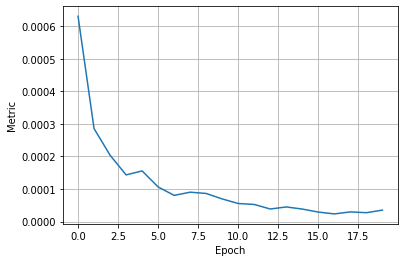

END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0006302565702325897,
              0.0002853919955195653,
              0.00020363062611061656,
              0.00014326888232757032,
              0.00015549638732128876,
              0.00010628202241977789,
              8.042762252456802e-05,
              9.022335187897933e-05,
              8.629670557060124e-05,
              6.948015648700022e-05,
              5.551609514717539e-05,
              5.2586029284844624e-05,
              3.857422756437082e-05,
              4.4935633285846576e-05,
              3.8407136232099407e-05,
              2.9187275219266346e-05,
              2.3530040112362952e-05,
              2.9736289596729546e-05,
              2.727169244572627e-05,
              3.517869299071256e-05]})

In [ ]:
torch.save(model, "streaming_crnn3.pt")

## Testing

In [ ]:
!wget https://zenodo.org/record/2529934/files/FSDnoisy18k.audio_test.zip

--2021-11-19 08:47:40--  https://zenodo.org/record/2529934/files/FSDnoisy18k.audio_test.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304186599 (290M) [application/octet-stream]
Saving to: ‘FSDnoisy18k.audio_test.zip’

FSDnoisy18k.audio_t 100%[===================>] 290.09M  10.1MB/s    in 31s     

2021-11-19 08:48:14 (9.22 MB/s) - ‘FSDnoisy18k.audio_test.zip’ saved [304186599/304186599]



In [ ]:
!mkdir noise && unzip -d noise FSDnoisy18k.audio_test.zip 1> log

In [ ]:
index_audio_with_keyword = val_df[val_df["label"] == 1].index[0]
index_audio_without_keyword = val_df[val_df["label"] == 0].index[:10]

In [ ]:
index_audio_with_keyword

74

In [ ]:
index_audio_without_keyword

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [ ]:
background_noises_path = ["/content/noise/FSDnoisy18k.audio_test/101383.wav",
                          "/content/noise/FSDnoisy18k.audio_test/101489.wav"]
background_noises = [
            torchaudio.load(p)[0].squeeze()
            for p in background_noises_path
        ]
audio_with_keyword = val_set[index_audio_with_keyword]['wav']
test_audio_hard = torch.cat((background_noises[0], audio_with_keyword,
                        background_noises[1])).to(config.device)
test_audio_hard.shape

torch.Size([622752])

In [ ]:
test_audio_easy_list = []
for i in range(len(index_audio_without_keyword)):
    test_audio_easy_list.append(val_set[index_audio_without_keyword[i]]['wav'])
half = len(index_audio_without_keyword) // 2
test_audio_easy = test_audio_easy_list[half:] + [audio_with_keyword]
test_audio_easy += test_audio_easy_list[:half]
test_audio_easy = torch.cat(test_audio_easy).to(config.device)
test_audio_easy.shape

torch.Size([168960])

In [ ]:
import gdown
url = "https://drive.google.com/uc?id=1mb9y-CBHCF41_7J26VwSwwbcmah-k4RR"
output = "/content/streaming_crnn3.pt"
gdown.download(url, output, quiet=False)
model = torch.load("/content/streaming_crnn3.pt")

Downloading...
From: https://drive.google.com/uc?id=1mb9y-CBHCF41_7J26VwSwwbcmah-k4RR
To: /content/streaming_crnn3.pt
100%|██████████| 288k/288k [00:00<00:00, 36.8MB/s]


In [ ]:
model.eval()

streaming_model = Streaming(model, 41)

melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)
test_audio_melspeced = torch.log(melspec(test_audio_easy).clamp_(min=1e-9, max=1e9))

output = streaming_model(test_audio_melspeced.unsqueeze(0))
probs = F.softmax(output, dim=-1)
test_audio_melspeced.shape

torch.Size([40, 1057])

(0.0, 1.0)

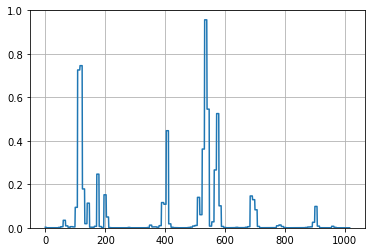

In [ ]:
plt.grid(True)
plt.plot(probs[0, :, 1].cpu().detach().numpy())
plt.ylim(0, 1)

In [ ]:
model.eval()

streaming_model = Streaming(model, 41)

melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)
test_audio_melspeced = torch.log(melspec(test_audio_hard).clamp_(min=1e-9, max=1e9))

output = streaming_model(test_audio_melspeced.unsqueeze(0))
probs = F.softmax(output, dim=-1)
test_audio_melspeced.shape

torch.Size([40, 3893])

(0.0, 1.0)

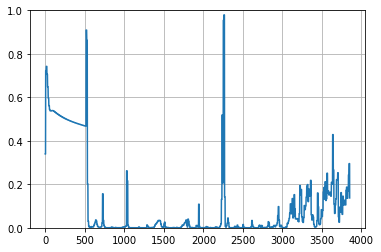

In [ ]:
plt.grid(True)
plt.plot(probs[0, :, 1].cpu().detach().numpy())
plt.ylim(0, 1)

Первый график -- результат стриминга на склеенных данных из валидации: так как там записи короткие + модель обучалась на очень похожих данных, график довольно гладкий. Второй график -- результат стриминга на шумах из внешнего набора данных, здесь запись подлиннее и посложнее, поэтому на графике больше флуктуаций, однако модель всё ещё хорошо распознает ключевое слово посередине.

# Speedup and compression

## Dark Knowledge Distillation

### Training

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [ ]:
config = TaskConfig()
config.cnn_out_channels = 4 # instead of 8
config.kernel_size = (5, 20)
config.stride = (2, 8)
config.hidden_size = 20 # instead of 64
config.gru_num_layers = 2 # instead of 2
config.dropout = 0
config.alpha = 0.84 # alpha is the share of distillation loss
config.temperature = 7
config.num_epochs = 50

smaller_model = CRNN(config).to(config.device)
smaller_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 20, num_layers=2, batch_first=True)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:
opt = torch.optim.Adam(
    smaller_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [ ]:
sum([p.numel() for p in smaller_model.parameters()])

9047

In [ ]:
def loss_fn_kd(outputs, labels, teacher_outputs, config):
    alpha = config.alpha
    T = config.temperature
    softmax_teacher_outputs = F.log_softmax(teacher_outputs / T, dim=1)
    KD_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(outputs / T, dim=1), softmax_teacher_outputs) * alpha + \
              F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss


def train_epoch_with_distillation(model, teacher_model, opt, loader,
                                  log_melspec, config):
    device = config.device
    model.train()
    teacher_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        with torch.no_grad():
            output_teacher = teacher_model(batch)
        loss = loss_fn_kd(logits, labels, output_teacher, config)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        probs = F.softmax(logits, dim=-1)
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1VegjNEvwCUcqkpIxiwrqgpHLFXeVK2Qo"
file = "base_crnn_model.pt"
gdown.download(url, file, quiet=False)
teacher_model = torch.load(file)

Downloading...
From: https://drive.google.com/uc?id=1VegjNEvwCUcqkpIxiwrqgpHLFXeVK2Qo
To: /content/base_crnn_model.pt
100%|██████████| 288k/288k [00:00<00:00, 51.3MB/s]


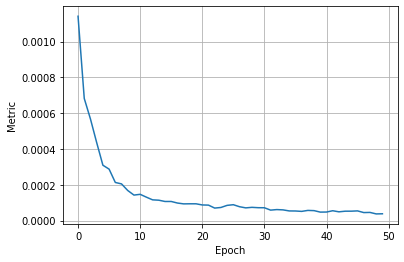

END OF EPOCH 49


In [ ]:
import copy
history = defaultdict(list)
best_model = None
best_metric = 100

for n in range(config.num_epochs):

    train_epoch_with_distillation(smaller_model, teacher_model, opt,
                                  train_loader, melspec_train, config)

    au_fa_fr = validation(smaller_model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)
    if best_metric > au_fa_fr:
        best_metric = au_fa_fr
        best_model = copy.deepcopy(smaller_model)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
best_metric

3.7153951240063845e-05

In [ ]:
needed_metric = 5e-05 * 1.1
needed_metric

5.500000000000001e-05

In [ ]:
torch.save(best_model, "final_distilled.pt")

### Profiling

In [ ]:
import gdown
url = "https://drive.google.com/uc?id=1vIk3LsheFCJ7m1zIpvhJ9IJgSivpwB4w"
file = "distilled_model.pt"
gdown.download(url, file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1vIk3LsheFCJ7m1zIpvhJ9IJgSivpwB4w
To: /content/distilled_model.pt
100%|██████████| 44.0k/44.0k [00:00<00:00, 10.1MB/s]


'distilled_model.pt'

In [ ]:
distilled_model = torch.load("distilled_model.pt")

In [ ]:
!pip install thop

In [ ]:
from thop import profile

def my_profile(model, loader, log_melspec, config):
    model.eval()
    for i, (batch, labels) in enumerate(loader):
        batch, labels = batch.to(config.device), labels.to(config.device)
        batch = log_melspec(batch)
        res = profile(model, (batch, ))  # -> (6.0 MACs, 3.0 parameters)
        break
    return res

In [ ]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

In [ ]:
def compare_time_and_space(teacher_model, distilled_model, val_loader, melspec_val, config):
    teacher_macs = my_profile(teacher_model, val_loader, melspec_val, config)
    distilled_macs = my_profile(distilled_model, val_loader, melspec_val, config)
    print("teacher_model:", teacher_macs)
    print("distilled_model:", distilled_macs)
    print(f"Distilled model takes {teacher_macs[0] / distilled_macs[0]} times less time.")

    teacher_memory = get_size_in_megabytes(teacher_model)
    distilled_memory = get_size_in_megabytes(distilled_model)
    print("teacher_model:", teacher_memory)
    print("distilled_model:", distilled_memory)
    print(f"Distilled model takes {teacher_memory / distilled_memory} times less space.")

In [ ]:
compare_time_and_space(teacher_model, distilled_model, val_loader, melspec_val, config)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


## DKD + Attention Distillation

### Training

In [ ]:
class AttentionWithSize(Attention):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__(input_size)
        self.energy = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2), alpha

class CRNNWithChangableAttentionSize(CRNN):
    def __init__(self, config: TaskConfig):
        super().__init__(config)
        self.attention = AttentionWithSize(config.hidden_size, config.att_hs)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector, alpha = self.attention(gru_output)
        output = self.classifier(contex_vector)
        if self.training:
            return output, alpha
        else:
            return output

In [ ]:
config = TaskConfig()
config.cnn_out_channels = 4 # instead of 8
config.kernel_size = (5, 20)
config.stride = (2, 8)
config.hidden_size = 20 # instead of 64
config.gru_num_layers = 2
config.dropout = 0
config.alpha = 0.84 # alpha is the share of distillation loss
config.temperature = 7
config.att_hs = 15
config.att_alpha = 0.3
config.num_epochs = 70

smaller_model = CRNNWithChangableAttentionSize(config).to(config.device)
smaller_model

CRNNWithChangableAttentionSize(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 20, num_layers=2, batch_first=True)
  (attention): AttentionWithSize(
    (energy): Sequential(
      (0): Linear(in_features=20, out_features=15, bias=True)
      (1): Tanh()
      (2): Linear(in_features=15, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:
opt = torch.optim.Adam(
    smaller_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [ ]:
sum([p.numel() for p in smaller_model.parameters()])

8937

In [ ]:
def get_teacher_output_with_alphas(teacher_model, input):
    input = input.unsqueeze(dim=1)
    conv_output = teacher_model.conv(input).transpose(-1, -2)
    gru_output, _ = teacher_model.gru(conv_output)
    energy = teacher_model.attention.energy(gru_output)
    alpha = torch.softmax(energy, dim=-2)
    contex_vector, alpha = (gru_output * alpha).sum(dim=-2), alpha
    output = teacher_model.classifier(contex_vector)
    return output, alpha


def loss_fn_att_kd(outputs, teacher_outputs, config):
    alpha = config.att_alpha
    KD_loss = nn.KLDivLoss()(outputs, teacher_outputs)
    return KD_loss


def loss_fn_kd(outputs, labels, teacher_outputs, config):
    alpha = config.alpha
    T = config.temperature
    softmax_teacher_outputs = F.log_softmax(teacher_outputs / T, dim=1)
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs / T, dim=1),
                             softmax_teacher_outputs) * alpha + \
              F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss


def train_epoch_with_distillation_and_att_dist(model, teacher_model, opt, loader,
                                  log_melspec, config):
    device = config.device
    model.train()
    teacher_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits, alphas = model(batch)
        with torch.no_grad():
            output_teacher, teacher_alphas = get_teacher_output_with_alphas(
                teacher_model, batch)
        loss = loss_fn_kd(logits, labels, output_teacher, config)
        loss += loss_fn_att_kd(alphas, teacher_alphas, config)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        probs = F.softmax(logits, dim=-1)
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1VegjNEvwCUcqkpIxiwrqgpHLFXeVK2Qo"
file = "base_crnn_model.pt"
gdown.download(url, file, quiet=False)
teacher_model = torch.load(file)

Downloading...
From: https://drive.google.com/uc?id=1VegjNEvwCUcqkpIxiwrqgpHLFXeVK2Qo
To: /content/base_crnn_model.pt
100%|██████████| 288k/288k [00:00<00:00, 54.3MB/s]


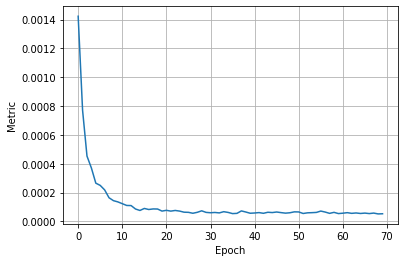

END OF EPOCH 69


In [ ]:
import copy
history = defaultdict(list)
best_model = None
best_metric = 100

for n in range(config.num_epochs):

    train_epoch_with_distillation_and_att_dist(smaller_model, teacher_model, opt,
                                  train_loader, melspec_train, config)

    au_fa_fr = validation(smaller_model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)
    if best_metric > au_fa_fr:
        best_metric = au_fa_fr
        best_model = copy.deepcopy(smaller_model)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
best_metric

5.1798313004136554e-05

In [ ]:
needed_metric = 5e-05 * 1.1
needed_metric

5.500000000000001e-05

In [ ]:
torch.save(best_model, "distilled_att_crnn_model.pt")

### Profiling

In [ ]:
import gdown
url = "https://drive.google.com/uc?id=1FUNijUOrmQQdd1nVsYRFqJ_tVwasXT_l"
file = "att_distilled_model.pt"
gdown.download(url, file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FUNijUOrmQQdd1nVsYRFqJ_tVwasXT_l
To: /content/att_distilled_model.pt
100%|██████████| 43.3k/43.3k [00:00<00:00, 10.9MB/s]


'att_distilled_model.pt'

In [ ]:
att_distilled_model = torch.load("att_distilled_model.pt")

In [ ]:
compare_time_and_space(teacher_model, att_distilled_model, val_loader, melspec_val, config)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:838: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


## Dynamic quantization


In [ ]:
import gdown
url = "https://drive.google.com/uc?id=1FUNijUOrmQQdd1nVsYRFqJ_tVwasXT_l"
file = "att_distilled_model.pt"
gdown.download(url, file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FUNijUOrmQQdd1nVsYRFqJ_tVwasXT_l
To: /content/att_distilled_model.pt
100%|██████████| 43.3k/43.3k [00:00<00:00, 11.0MB/s]


'att_distilled_model.pt'

In [ ]:
att_distilled_model = torch.load("att_distilled_model.pt").to("cpu")

In [ ]:
model_int8 = torch.quantization.quantize_dynamic(
    att_distilled_model,  # the original model
    {torch.nn.Linear, torch.nn.GRU},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [ ]:
cpu_config = TaskConfig()
cpu_config.device = "cpu"
melspec_val_cpu = LogMelspec(is_train=False, config=cpu_config)

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1VegjNEvwCUcqkpIxiwrqgpHLFXeVK2Qo"
file = "base_crnn_model.pt"
gdown.download(url, file, quiet=False)
teacher_model = torch.load(file).to("cpu")

Downloading...
From: https://drive.google.com/uc?id=1VegjNEvwCUcqkpIxiwrqgpHLFXeVK2Qo
To: /content/base_crnn_model.pt
100%|██████████| 288k/288k [00:00<00:00, 39.5MB/s]


In [ ]:
teacher_memory = get_size_in_megabytes(teacher_model)
distilled_memory = get_size_in_megabytes(model_int8)
print("teacher_model:", teacher_memory)
print("quantized_model:", distilled_memory)
print(f"Quantized model takes {teacher_memory / distilled_memory} times less space.")

teacher_model: 0.27299976348876953
quantized_model: 0.01712322235107422
Quantized model takes 15.943247006404901 times less space.


In [ ]:
validation(model_int8, val_loader, melspec_val_cpu, "cpu")

102it [00:12,  8.13it/s]


5.1977339431570206e-05

In [ ]:
needed_metric = 5e-05 * 1.1
needed_metric

5.500000000000001e-05

In [ ]:
torch.save(model_int8, "quantized_crnn_model.pt")